# Section 1: Introduction & Background

With our increasing reliance on digital platforms and social media sites, content moderation has become a key component of online platforms. Toxicty, hate speech, etc. can have detrimental impacts on a range of users and handling them becomes key specially when vulnerable groups such as young children increase usage of such platforms.

Content moderation to a certain extent is done by human teams that look out for content that might not be appropriate for the platform, and this task has the potential to lead to a number of issues including anxiety and depression for moderators.

Thus, we decided to undertake our project in this area and more specifically on the automatic identification of toxic comments among tweets. Our objective was two fold -- firstly to analyse what constitutes a toxic tweet and whether we can determine a quantitative, data-driven framework to identify toxicity and secondly, to develop a predictive model to identify potentially toxic tweets that can serve as a blueprint for the development of an automatic content moderator

#Section 2: Imports

##Libaries

This section involves importing all relevant libraries for the project. The libraries used span data-specific technologies, such as Pandas and Numpy, as well as Machine Learning-based models and utilities, such as Sk-Learn and NLTK. 

In [ ]:
!pip install pyLDAvis
!pip install imbalanced-learn
!pip install --upgrade gensim
!pip install scikit-multilearn
!pip install xgboost

Requirement already up-to-date: gensim in /usr/local/lib/python3.6/dist-packages (3.8.3)


In [ ]:
# General Imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import re
import os
from collections import Counter
import string
import statistics
from bs4 import BeautifulSoup
import html
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from scipy.stats import ttest_ind
from dateutil import parser
style.use('fivethirtyeight')

In [ ]:
# Model Imports
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, precision_score, recall_score, \
        f1_score, roc_auc_score, hamming_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import plot_confusion_matrix

from skmultilearn.problem_transform import BinaryRelevance, ClassifierChain
from sklearn.naive_bayes import MultinomialNB

from xgboost import XGBClassifier

import gensim
from gensim.models import CoherenceModel

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import pyLDAvis
import pyLDAvis.gensim

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
# Keras Imports
from keras.models import Model
from keras.layers import Dense
from keras.layers import Embedding
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import GlobalMaxPool1D
from keras.layers import Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [ ]:
# NLTK Imports
import nltk
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")
nltk.download('averaged_perceptron_tagger')
from nltk import ngrams, word_tokenize, sent_tokenize, pos_tag
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords, wordnet

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
# missingno Imports
!pip install missingno
import missingno

##Datasets

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


This section involves loading in our dataset into the programming environment. The dataset is sourced from Kaggle [here](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge), and involves a data problem to identify toxic comments based on their textual data. Through this project, we hope to not only be able to develop a system that is able to identify the category of toxicity (or clean if it is not toxic) of a comment, but also get a stronger understanding of the kind of patterns that we see that lead to a comment being deemed 'toxic'.

The dataset consists of 7 main columns (excluding the comment id). One of these is **comment_text** which contains the tweet that is going to be analysed. The other 6 are columns reflecting different categories of toxicity with the value 1 in the columns indicating that the tweet falls in this class and 0 otherwise. These categories, as seen below, are: **toxic**, **severe_toxic**, **obscene**, **threat**, **insult**, and **identity_hate**

In [ ]:
# Load data into Collab
df = pd.read_csv('drive/MyDrive/train.csv')

comment_df = df.copy()
comment_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# Section 3: Data Cleaning & Feature Engineering

## High-Level

We can now conduct some basic processing on the entire dataset to allow for easy processing of data down the line. 

In [ ]:
# converting the type of the text column to be strings
comment_df['comment_text'] = comment_df['comment_text'].astype('str')

In [ ]:
# getting an indication of the dataset's magnitude
comment_df.shape

(159571, 8)

In [ ]:
# creating a list of categories that are identified
CATEGORIES = ['toxic', 'severe_toxic', 'obscene',	'threat', 'insult', 'identity_hate']

In [ ]:
# creating a new category 'clean' for comments that don't fall into any of the categories
comment_df['clean'] = comment_df[CATEGORIES].sum(axis = 1).apply(lambda x: 1 if x == 0 else 0)
CATEGORIES.append('clean')
comment_df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1


## Exploratory Data Analysis

After this, we can gain a better understanding of our data distribution by conducting basic visualizations on it. This involves getting an idea of the data distribution, as well as understanding how much (if any) data is missing.

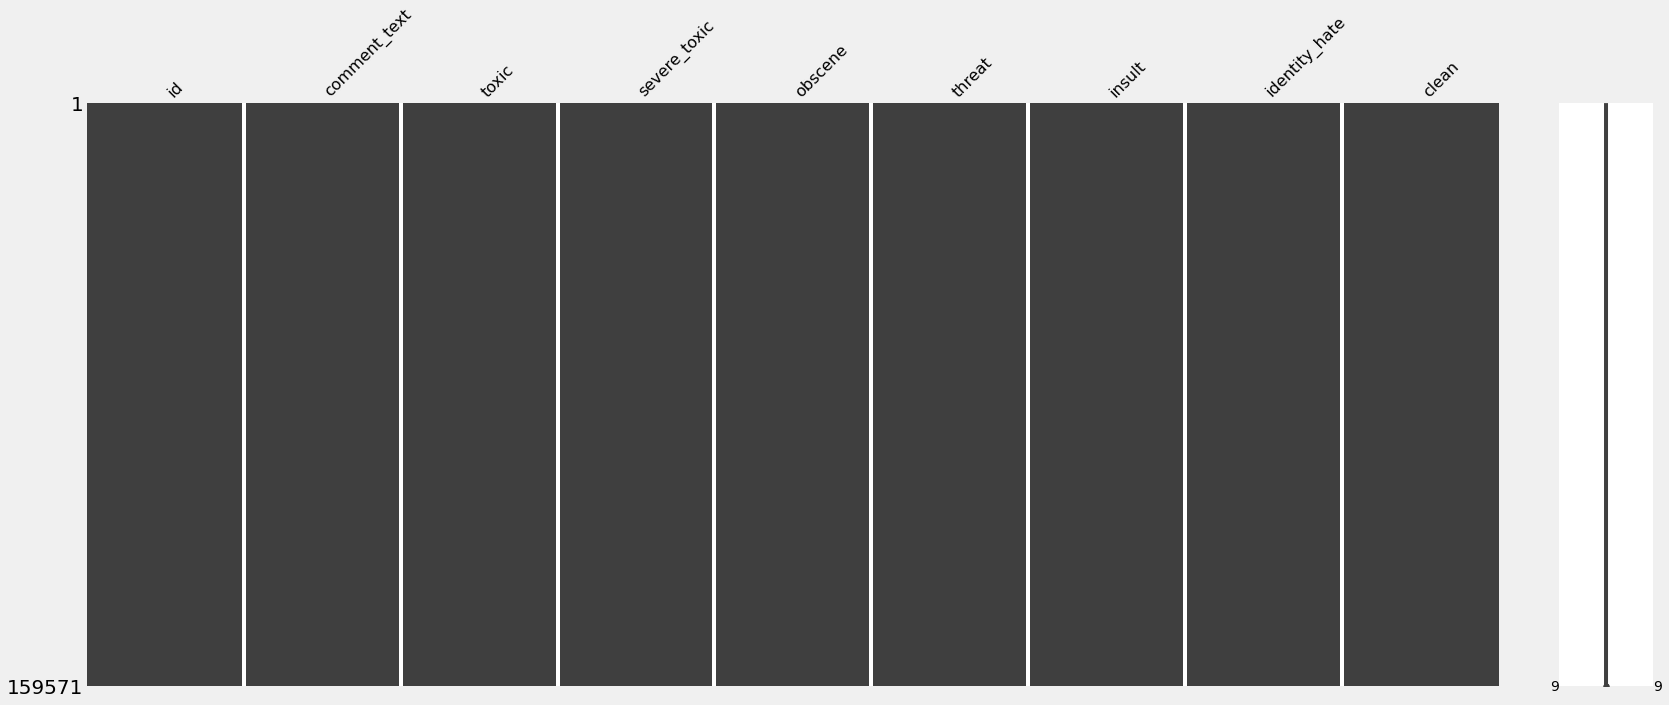

In [ ]:
# checking missing values - none, indicating that we are good to go
missingno.matrix(comment_df)

As seen in the above visualisation, none of the data is missing and thus, we can skip the imputation step

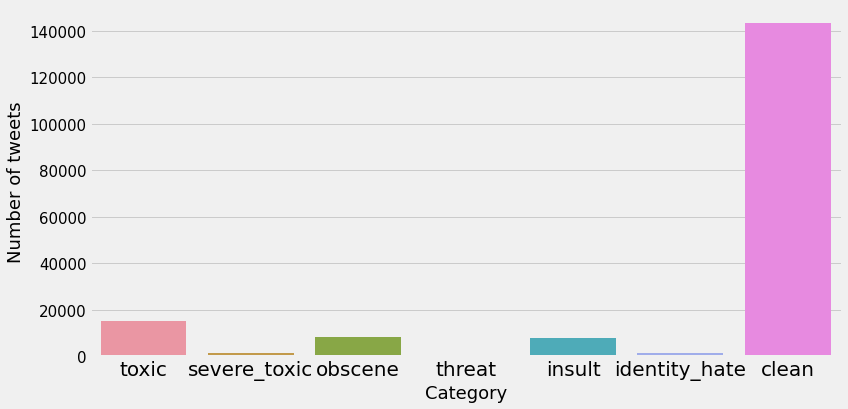

In [ ]:
# visualizing the class balance - skewed with majority being clean
labels_df = comment_df.drop(columns = ['id', 'comment_text'])
count_labels = labels_df.sum()
fig, ax = plt.subplots(figsize = (12, 6))
ax.set_ylabel("Number of tweets")
ax.set_xlabel("Category")
g = sns.barplot(x = count_labels.index, y = count_labels.values, ax = ax)

Majority of the tweets are in the clean category with a somewhat uneven distribution within other categories. 

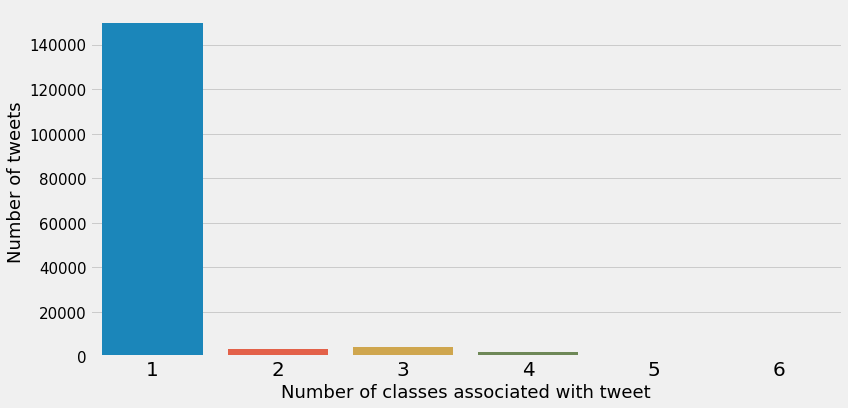

In [ ]:
# visualizing the overlap in non-clean classes
cnt_overlap = labels_df.sum(axis = 1).value_counts()
fig, ax = plt.subplots(figsize = (12, 6))
ax.set_ylabel("Number of tweets")
ax.set_xlabel("Number of classes associated with tweet")
sns.barplot(x = cnt_overlap.index, y = cnt_overlap.values, ax = ax)

There does exist some overlap among the different classes. A significant majority tweets are classified into only one class. This is potentially due to clean tweets being a bulk of the dataset. Regardless, there are tweets classified into as many as 4 classes, indicating that modelling would require multilabel classification in addition to traditional methods

## Feature Generation

As of now, the only feature that we have is the raw text data from the comment. In order for us to build models, we must extract a series of features that indicate to us in numerical terms whether or not a comment is toxic. We hence consider a series of numerical indicators - features such as average word length and ratio of punctuation marks to number of words - that are more explainable than the raw text data itself. The features were chosen while keeping in mind potential differences that might exist in toxic and profane tweets as opposed to normal ones. Note that we do this before comment cleaning as cleaning would lead to some information about the tweet being lost that may have been reflective of toxicity. Thus, we perform this analysis to get an understanding of features from the raw tweets.

In order to implement this, we create a new column for each new feature, and assign each comment a numerical value that corresponds to the feature in the column it represents. For example, if we look at the feature that describes the ratio of capitalized words to word count, we create a new column that represents this and calculate this value for each comment in the dataset.

In [ ]:
# define function to calculate number of capital words in the tweet
def count_capital(word):
  cnt = 0
  for w in word.split(' '):
    if w.isupper():
      cnt += 1
  return cnt

# Ratio of capital words to word count
comment_df['capital_to_word'] = comment_df.comment_text.apply(lambda x: count_capital(x) / len(x.split(' ')))

In [ ]:
# define function to number of punctuations in the tweet
def count_punctuation(word):
  cnt = 0
  for w in word:
    if w in string.punctuation:
      cnt += 1
  return cnt

# Ratio of number of punctuations to word count
comment_df['punct_to_word'] = comment_df.comment_text.apply(lambda x: count_punctuation(x) / len(x.split(' ')))

In [ ]:
# number of sentences
comment_df['sent_length'] = comment_df.comment_text.apply(lambda x: len(re.findall('\n', x)))

# word count
comment_df['word_count'] = comment_df.comment_text.apply(lambda x: len(x.split(' ')))

# average word length 
comment_df['word_length'] = comment_df.comment_text.apply(lambda x: statistics.mean((map(len, x.split(' ')))))

# number of unique words
comment_df['num_unique'] = comment_df.comment_text.apply(lambda x: len(set(x.split(' '))))

In [ ]:
# number of exclamation marks relative to word count
comment_df['num_exclamations'] = comment_df.comment_text.apply(lambda x: len(re.findall('!', x)) / len(x.split(' ')))

# max number of repeated words relative to word count:
comment_df['max_repetitions'] = comment_df.comment_text.apply(lambda x: Counter(x.split(' ')).\
                                                      most_common()[0][1]) / comment_df.word_count

# number of stopwords to the word count
s = stopwords.words("english")
comment_df['num_stopwords'] = comment_df.comment_text.apply(lambda x: len([w for w in x.split(' ') \
                                                                           if w in s])) / comment_df.word_count

Now, we can visualize what our dataset looks like with the new meta-features we have generated that describe the textual data. We see a number of new columns that contain information embedded within the 'comment_text' column.

In [ ]:
comment_df.head(5)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean,capital_to_word,punct_to_word,sent_length,word_count,word_length,num_unique,num_exclamations,max_repetitions,num_stopwords
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1,0.047619,0.238095,1,42,5.309524,40,0.000000,0.071429,0.333333
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1,0.055556,0.666667,0,18,5.277778,18,0.055556,0.055556,0.055556
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1,0.000000,0.142857,0,42,4.571429,39,0.000000,0.071429,0.428571
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1,0.035714,0.187500,4,112,4.562500,82,0.000000,0.035714,0.437500
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1,0.000000,0.384615,0,13,4.230769,13,0.000000,0.076923,0.307692


## Comment Cleaning

Our comments currently contain a lot of messiness in them - they contain HTML tags, stopwords, punctuation marks and URLs, among other things, which are not easily interpretable and could add unwanted noise to our models in addition to being misleading during some future EDA. As a result, we can define a function 'clean_tweet' that is responsible for taking in an input comment as a string, and then returning a cleaned version of the tweet. We use two sets - s (which stores all possible stopwords) and p (which stores all possible punctuation marks) to assist us in this.

In [ ]:
#Helper function to identify dates
def is_not_date(string):
  try:
    parser.parse(string)
    return False
  except:
    return True

In [ ]:
# declaration of helper sets
s = stopwords.words('english')
p = string.punctuation

# function to clean a comment
def clean_tweet(tweet):
  # convert html chars into text and remove HTML tags
  tweet = html.unescape(tweet)

  # convert to lower case
  tweet = ' '.join(x.lower() for x in tweet.split())

  #remove stopwords
  tweet = ' '.join(x for x in tweet.split() if x not in s and x.isalpha())

  # remove punctuation
  tweet = ''.join(x for x in tweet if x not in p)

  # remove URL
  tweet = re.sub(r"https?://\S+|www\.\S+", '', tweet).strip()

  # remove hashtags
  tweet = re.sub(r'\B(\#[a-zA-Z]+\b)', '', tweet).strip()

  #Remove date and time
  tweet = ' '.join(x for x in tweet.split() if is_not_date(x))
  
  return tweet

Following this, we can tokenize the text in the dataset - this involves looking at all of the comments that fall under one particular label (toxic, for example), and returning a dictionary of words that are part of comments under this label.

The 'tokenize' function returns a dictionary of labels mapped to lists of words that fall under the label. Here, we firstly transform our tweets into a list of words using nltk's word_tokenize. In addition, we perform lemmatisation which is a step to reduce words back to their root form. We use nltk's WordNetLemmatizer. To perform effectively, the WordNetLemmatizer needs as an input the Part of Speech tag of the word however, wordnet tags are slightly different from the POS tags obtained through the traditional pos_tag function of NLTK. Thus, we first define a function to map our normal POS tags to what is required for the lemmatisation task

In [ ]:
def pos_to_wordnet(word):
  pos_tag_ref = nltk.pos_tag([word])[0][1][0]
  pos_tag_ref = pos_tag_ref.upper()
  wordnet_pos_ref = {"J": wordnet.ADJ,
              "N": wordnet.NOUN,
              "V": wordnet.VERB,
              "R": wordnet.ADV}

  return wordnet_pos_ref.get(pos_tag_ref, wordnet.NOUN)

In [ ]:
# function to tokenize text
def tokenize(comment_df):
  lemmatizer = WordNetLemmatizer()
  word_dict_comb = {key: [] for key in CATEGORIES}
  word_dict = {key: [] for key in CATEGORIES}
  for cat in CATEGORIES:
    #Extract df with tweets only in specific category
    df_cat = comment_df[comment_df[cat] == 1]
    for tweet in df_cat['comment_text']:
      word_token = word_tokenize(tweet)
      word_token = [lemmatizer.lemmatize(word, pos_to_wordnet(word)) for word in word_token]
      word_dict[cat].append(word_token)
      word_dict_comb[cat] += word_token

  return word_dict, word_dict_comb

Now, we can apply these cleaning and tokenzing functions to our dataset.

In [ ]:
# clean and tokenize text
comment_df['comment_text'] = comment_df.comment_text.apply(lambda x: clean_tweet(x))
word_dict, word_dict_comb = tokenize(comment_df)

In [ ]:
# lets take a look at the first two comments of toxic, class
word_dict['toxic'][:2]

[['cocksucker', 'piss', 'around', 'work'],
 ['talk',
  'exclusive',
  'group',
  'wp',
  'good',
  'purist',
  'gang',
  'one',
  'asks',
  'question',
  'abt',
  'destructive',
  'ask',
  'sityush',
  'clean',
  'behavior',
  'issue',
  'nonsensical']]

We can again view our dataset to see what our comments now look like - we see that we no longer have any stopwords, and the remaining words in each sentence are all descriptive.

In [ ]:
# view processed columns
comment_df.head()


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean,capital_to_word,punct_to_word,sent_length,word_count,word_length,num_unique,num_exclamations,max_repetitions,num_stopwords
0,0000997932d777bf,explanation edits made username hardcore metal...,0,0,0,0,0,0,1,0.047619,0.238095,1,42,5.309524,40,0.000000,0.071429,0.333333
1,000103f0d9cfb60f,matches background colour seemingly stuck,0,0,0,0,0,0,1,0.055556,0.666667,0,18,5.277778,18,0.055556,0.055556,0.055556
2,000113f07ec002fd,hey really trying edit guy constantly removing...,0,0,0,0,0,0,1,0.000000,0.142857,0,42,4.571429,39,0.000000,0.071429,0.428571
3,0001b41b1c6bb37e,make real suggestions improvement wondered sec...,0,0,0,0,0,0,1,0.035714,0.187500,4,112,4.562500,82,0.000000,0.035714,0.437500
4,0001d958c54c6e35,chance remember page,0,0,0,0,0,0,1,0.000000,0.384615,0,13,4.230769,13,0.000000,0.076923,0.307692


## Managing Access

We can now generate copies of the dataset we have crafted so far, to ensure that no changes are made to the master copy. This allows for us to manipulate distinct copies of the dataset in different sections of our code, while still maintaining access to the original dataset. 

We can also define a pair of tuples of columns that can be used to index the features and the label columns.

In [ ]:
# create a copy to make visualisation edits on
features_df = comment_df.copy()
topic_df = comment_df.copy()
model_df = comment_df.copy()

In [ ]:
# define indexing columns
feats = ('sent_length',	'word_count',	'word_length',	
     'num_unique',  'capital_to_word',	'num_exclamations',	'max_repetitions',
     'num_stopwords',	'punct_to_word')
cols = ('toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate', 'clean')

In [ ]:
#to speed up access later - internal
comment_df.to_csv('preprocessed_data.csv')

# Section 4: Data Visualization

## Variable Correlations

We can now look into understanding the correlation between three distinct column pairings - between features themselves, between labels themselves and between features & labels. Through the heatmaps produced, we can come to several conclusions, some of which are noted as follows:
*   Strong correlations exist between the number of unique words in a comment and other features. For example, it has a strong positive correlation with sentence length and word count, while it has a strong negative correlation with the the max number of repetitions. 
*   There is a reasonably strong degree of correlation between most non-clean labels - this is because they can all be deemed to fall under the general label of being 'toxic'.
*   Certain features in the dataset seemingly have little to no correlation with the label columns. Such features include the number of punctuation marks and the number of exclamations.
*   However, other features did have strong correlations - these included the count of capitals and the number of repeated words in the comment.

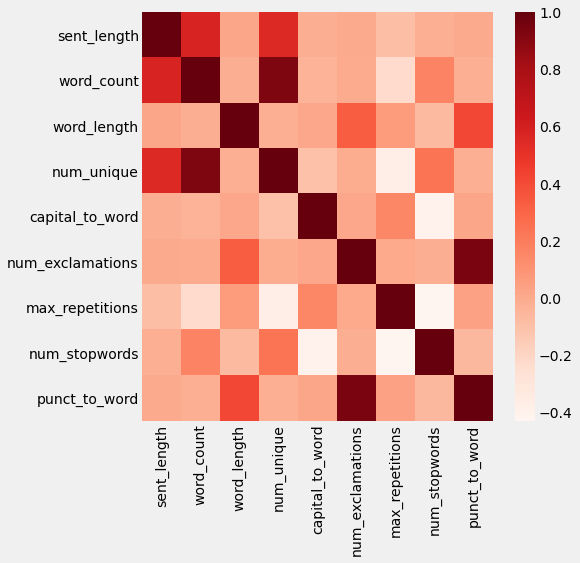

In [ ]:
# plotting correlations between features
plt.figure(figsize = (7, 7))
corrs = features_df[list(feats)].corr()
sns.heatmap(corrs, cmap = plt.cm.Reds)
plt.show()

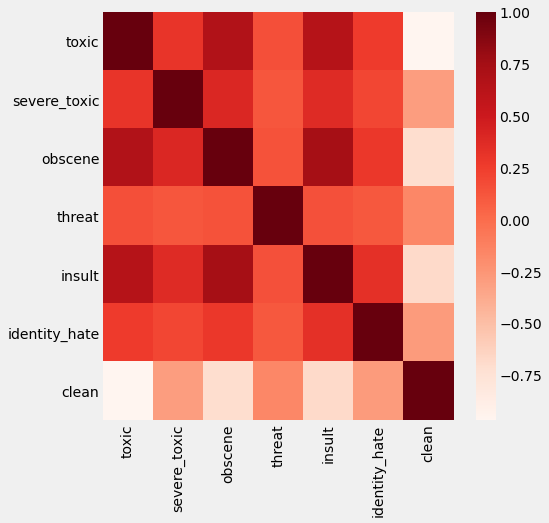

In [ ]:
# plotting correlations between labels - Cramer V???
plt.figure(figsize = (7,7))
corrs = features_df[list(cols)].corr()
sns.heatmap(corrs, cmap = plt.cm.Reds)
plt.show()

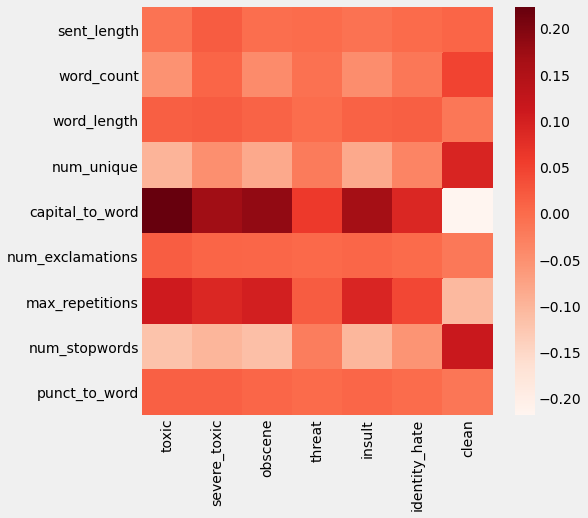

In [ ]:
# plotting correlations between features and output labels
plt.figure(figsize = (7,7))
rows = [{c: features_df[f].corr(features_df[c]) for c in cols} for f in feats]
corrs = pd.DataFrame(rows, index = feats)
sns.heatmap(corrs, cmap = plt.cm.Reds)
plt.show()

Next, we can examine the relationship between several features and whether or not they fall under one of the toxic labels, and utilize plots and hypothesis tests to understand whether or not they are an indicator of difference between the two categories. We can note our conclusions below as follows:
*   Sentence length does not have a significant influence on whether or not a comment is toxic, as the generated violin plot shows this distribution to be similar.
*   Similarly, average word length was not found to be a significant indicator as the plots looked reasonably similar between each class.
*   However, we do see differences in distribution for the word count - clean comments seem to have a higher median word count than toxic comments. In general, it appears that clean comments are likely to be longer
*   The distribution for the number of stopwords was reasonably consistent between each class. 
*   We see that the number of repetitions seems to be more evenly distributed in toxic comments, despite the median being similar for each of the two categories.

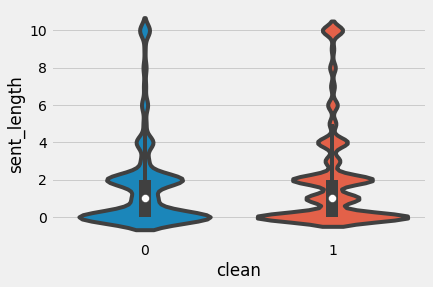

In [ ]:
# sentence length on toxic and non-toxic comments (cap it at 10 for viz)
features_df.loc[features_df.sent_length > 10, 'sent_length'] = 10
sns.violinplot(x = 'clean', y = 'sent_length', data = features_df)

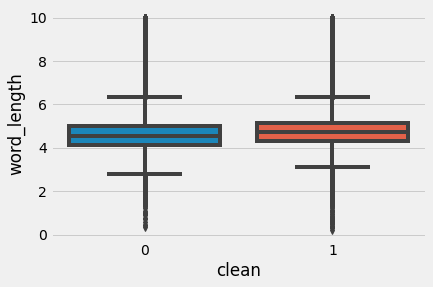

In [ ]:
# average word length compared
features_df.loc[features_df.word_length > 10, 'word_length'] = 10
sns.boxplot(x = 'clean', y = 'word_length', data = features_df)

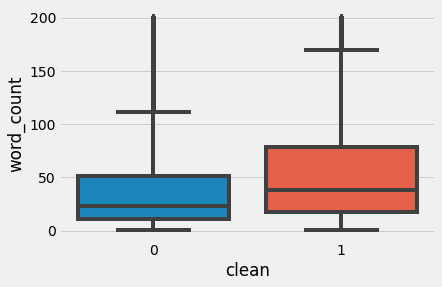

In [ ]:
# word count comparision
features_df.loc[features_df.word_count > 200, 'word_count'] = 200
sns.boxplot(x = 'clean', y = 'word_count', data = features_df)

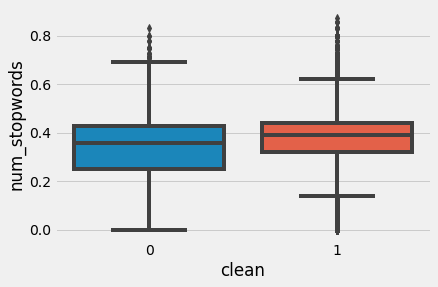

In [ ]:
# number of stopwords
# features_df.loc[features_df.word_count > 40, 'num_stopwords']
sns.boxplot(x = 'clean', y = 'num_stopwords', data = features_df)

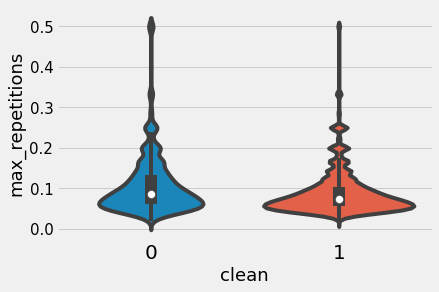

In [ ]:
# number of repetitions

#Cap at 0.5 to for better visualisation
features_df.loc[features_df.max_repetitions > 0.5, 'max_repetitions'] = 0.5
sns.violinplot(x = 'clean', y = 'max_repetitions', data = features_df)

## Word Clouds

For the next step, we can use the tokenized dictionaries that contained the words in comments that fall under each label, and then generate word clouds for each possible label type to get an understanding of what the most important / common words are in each.

We see clearly that while the words under the 'clean' category are reasonably neutral, without significant positive or negative leanings, they words under the various toxic categories are extremely offensive. We further see similarities between common words accross a number of toxic categories, reflecting the likely overlap between a few, however, we can further observe that common words under the threat class are slightly different from other toxic categories

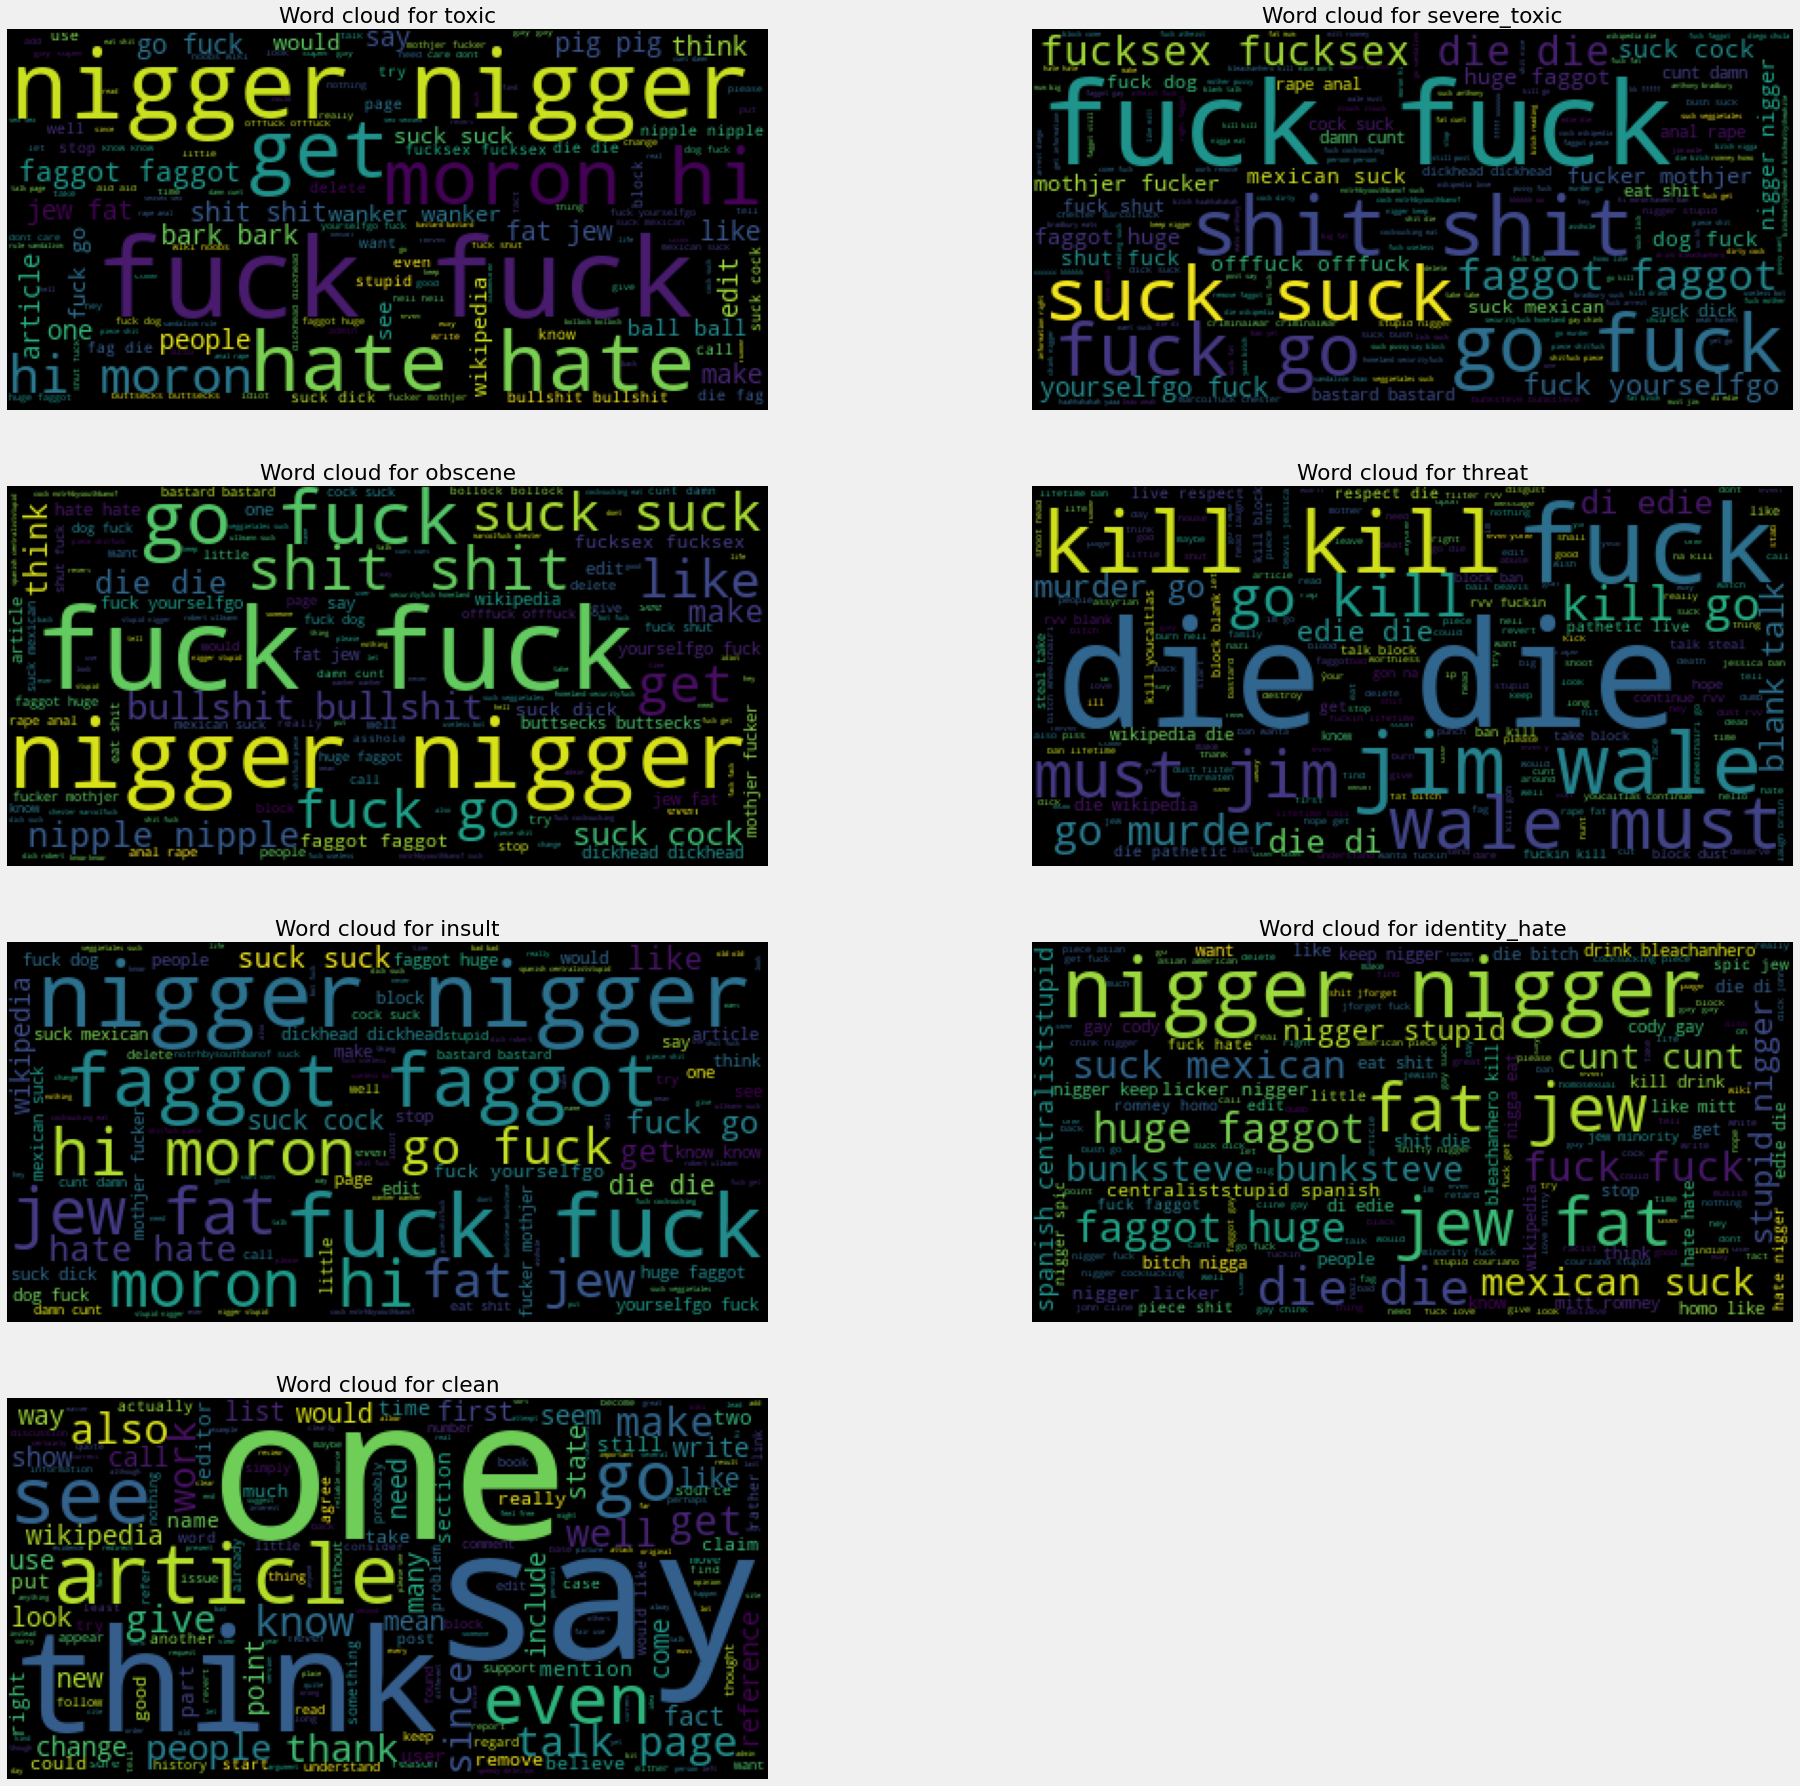

In [ ]:
# word clouds for each category
cnt = 1
plt.figure(figsize = (30,30))
plt.rcParams.update({'font.size': 15})
for cat in CATEGORIES:
  plt.subplot(4, 2, cnt)
  wordcloud = WordCloud(background_color="black", max_words = 3000, stopwords = stopwords.words('english'))
  words = ' '.join(word for word in word_dict_comb[cat])
  wordcloud.generate(words)

  plt.imshow(wordcloud, interpolation = 'bilinear')
  plt.axis("off")
  plt.title('Word cloud for ' + cat)
  plt.imshow(wordcloud)

  cnt += 1

## Per-Class n-grams

Next, we can explore some of the unigrams present in the various labels assigned to comments in the dataset. This will give us a more relitavized indication of which words are most common for each label, as well as how common they are in comparison to other terminology that is part of language that falls under the same umbrella. Similar to before, we see that while offensive terms significantly dominate the charts for the toxic categories, we have a series of neutral terms for the 'clean' label.

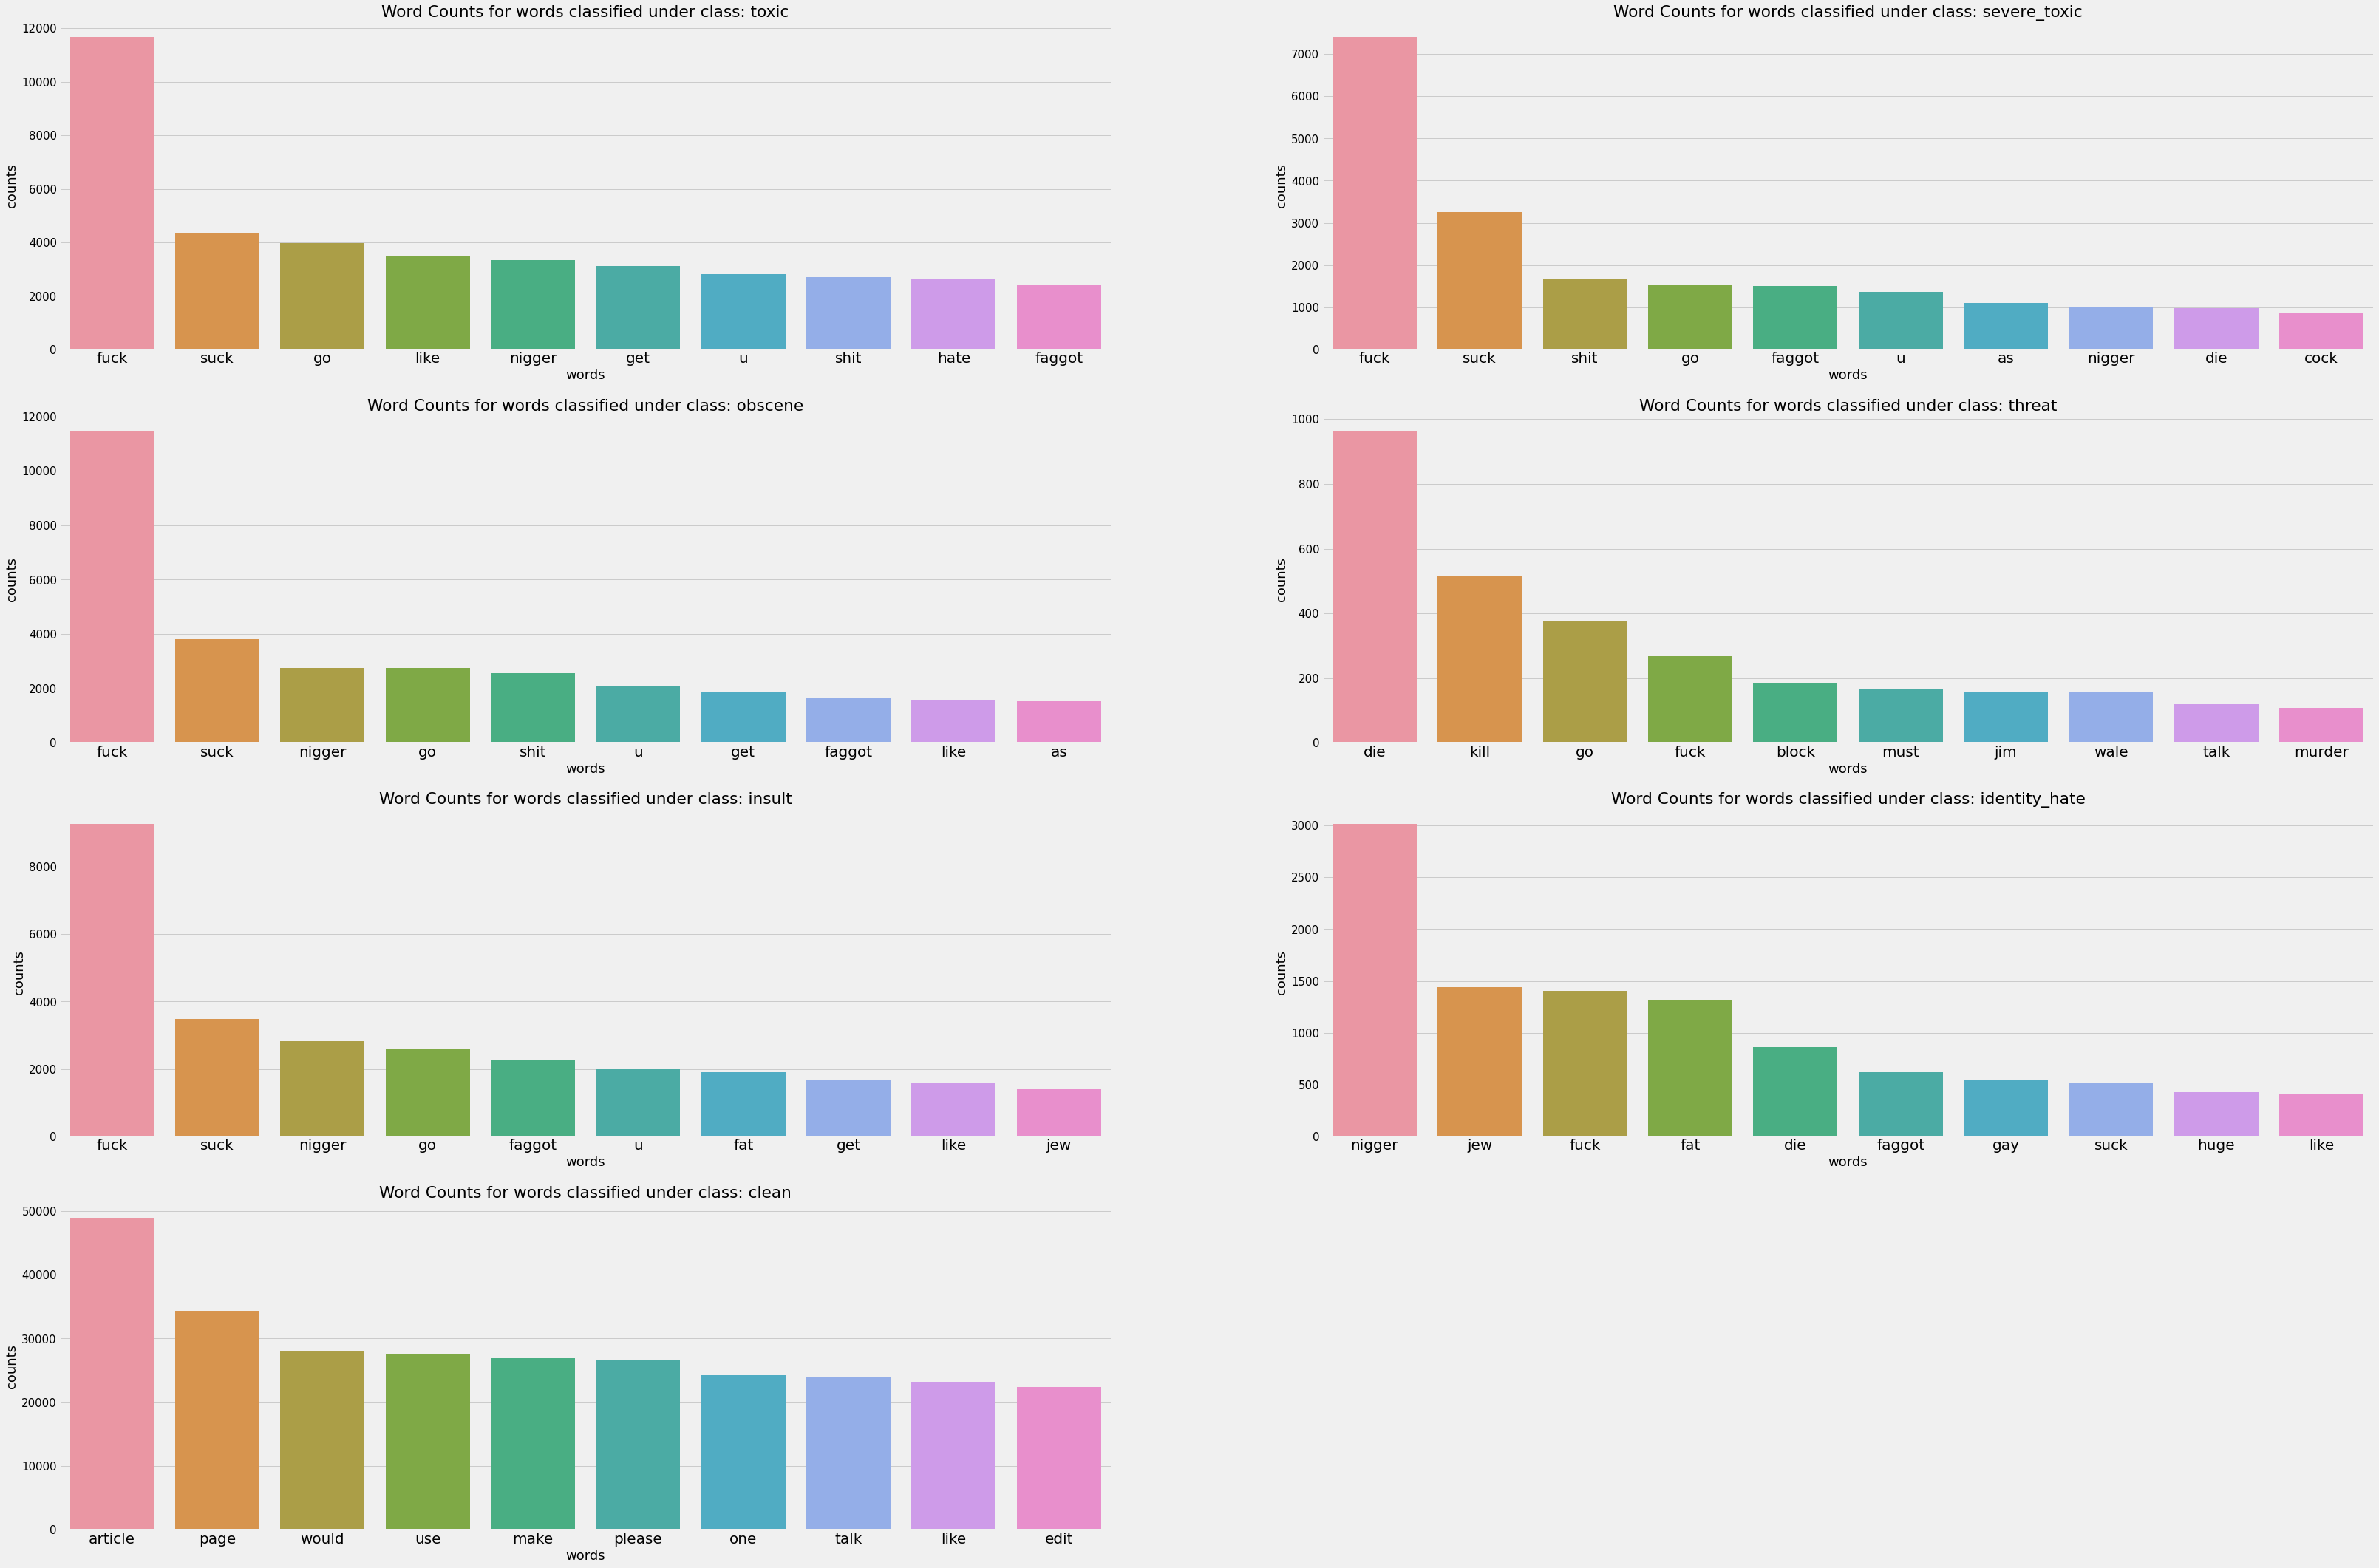

In [ ]:
# explore the words/unigrams for clean class
cnt = 1
plt.figure(figsize = (50,35))
plt.rcParams.update({'font.size': 15})
plt.rc('xtick', labelsize=20) 

for cat in CATEGORIES:
  plt.subplot(4, 2, cnt)
  word_cnt = Counter(word_dict_comb[cat])
  df_cnt = pd.DataFrame(word_cnt.most_common(10), columns = ['words', 'counts'])

  sns.barplot(x = 'words', y = 'counts', data = df_cnt)
  plt.title('Word Counts for words classified under class: ' + cat)
  cnt += 1

Similarly, we can explore some of the bigrams present in the various labels assigned to comments in the dataset. This could allow us to extract information about pairs of words that are common, as well as how common they are in comparison to other terminology. We now see two-term insults dominate the charts, as well as repeated terms, though the clean label still maintains a set of neutral terms..

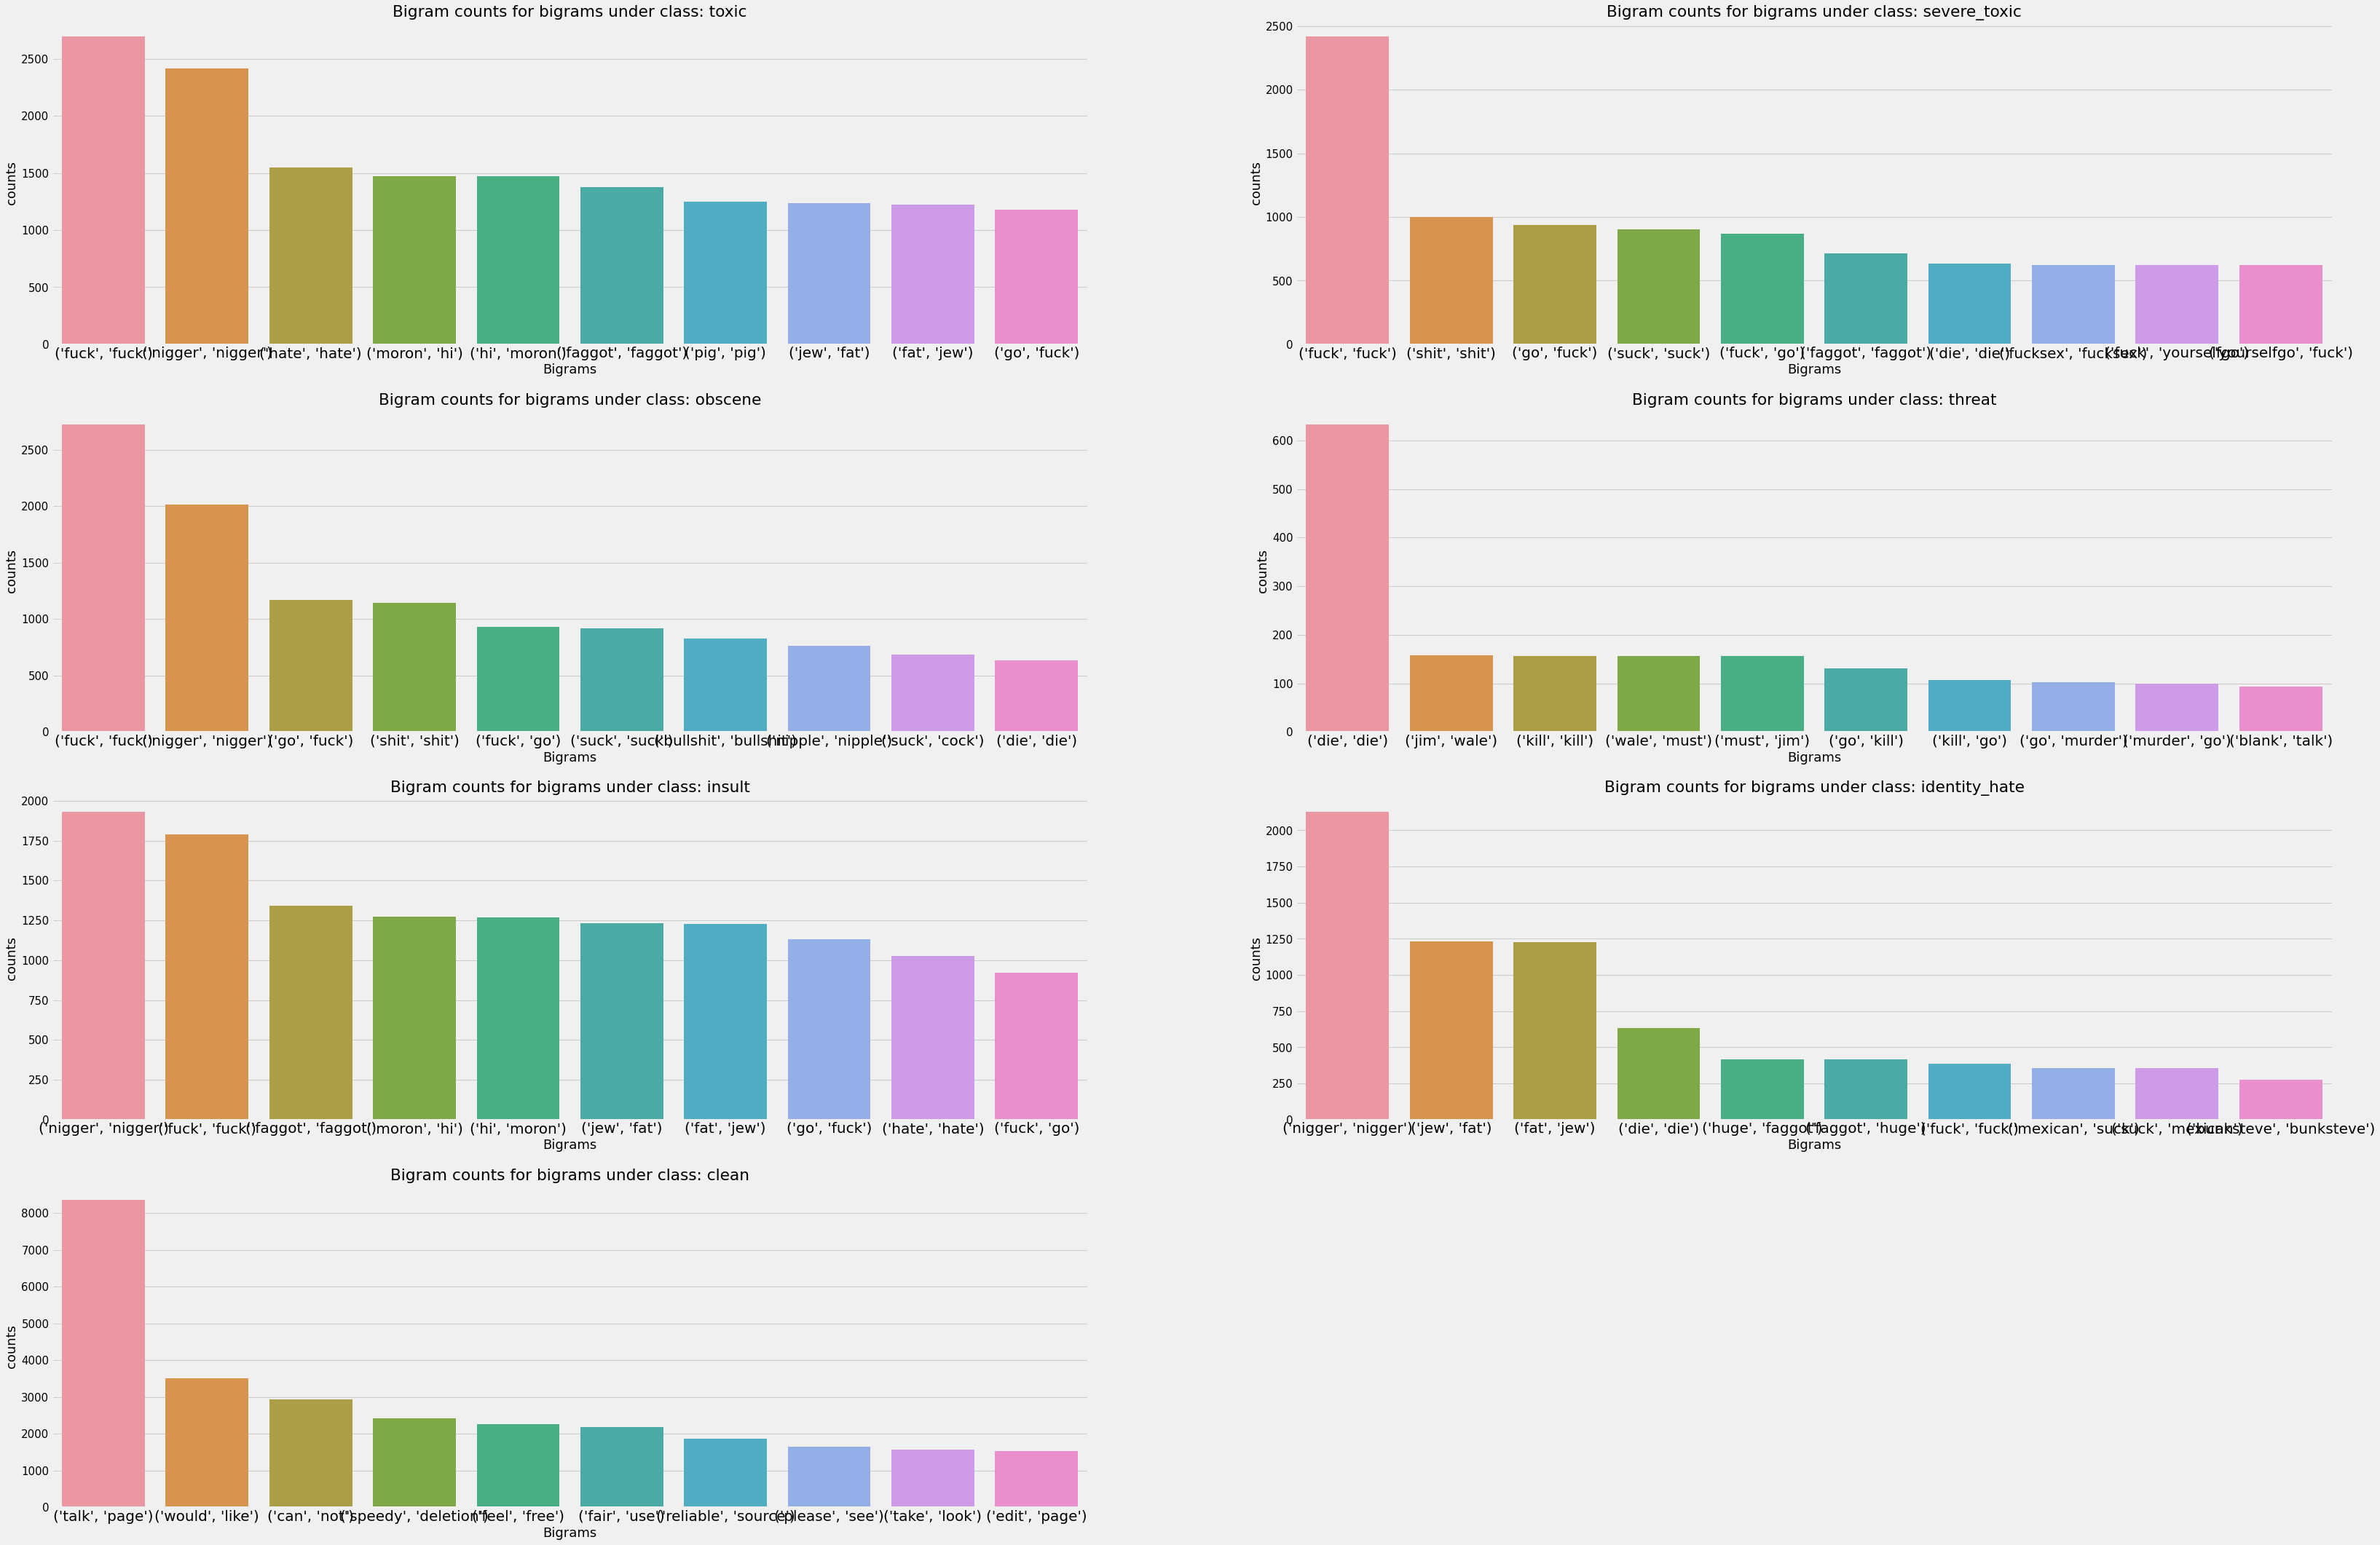

In [ ]:
cnt = 1
plt.figure(figsize = (50,35))
plt.rcParams.update({'font.size': 15})
plt.rc('xtick', labelsize=20) 
for cat in CATEGORIES:
  plt.subplot(4, 2, cnt)
  word_cnt = Counter(list(ngrams(word_dict_comb[cat], 2)))
  df_cnt = pd.DataFrame(word_cnt.most_common(10), columns = ['words', 'counts'])

  sns.barplot(x = 'words', y = 'counts', data = df_cnt)
  plt.title('Bigram counts for bigrams under class: ' + cat)
  plt.xlabel('Bigrams')
  cnt += 1

## Textual Data Features

Afer we have analysed the n-grams, we can conduct a series of hypothesis tests and create barplots to understand whether or not certain features correspond to strong indicators of difference between clean and non-clean (toxic) comments. This hypothesis test takes the null hypothesis to be the fact that a particular feature is not an inherent difference between the two classes. After conducting these tests, we get the following results:
*   The use of exclamations is an indicator of difference between clean and non-clean comments, given its low p-value and high t-test value. 
*   The use of repetitions is a strong indicator of difference between clean and non-clean comments, given its extremely low p-value and extremely high t-test value. This could be a result of the fact that trolls - who are prone to post negative comments - often utilize repeated words or phrases.
*   The use of capitalizations is almost certainly an indicator of difference between clean and non-clean comments, given its extremely low p-value and extremely high t-test value. This could be due to the fact that negative comments tend to be strongly associated with loud voices, hence the capitals as they often refer to projecting with a loud voice.


t-test: 2.2398869975696396
p-value: 0.025111743630376198


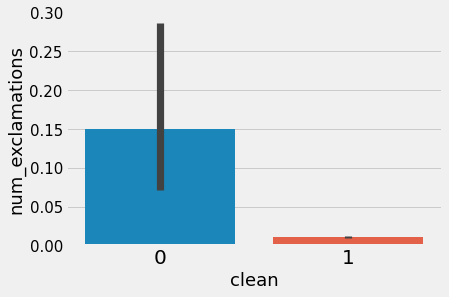

In [ ]:
# compare use of exclamations
sns.barplot(x = 'clean', y = 'num_exclamations', data = features_df)

# hypothesis test
cat1 = features_df[features_df['clean'] == 0]
cat2 = features_df[features_df['clean'] == 1]
t = ttest_ind(cat1['num_exclamations'] , cat2['num_exclamations'], equal_var = False)
print("t-test: " + str(t.statistic))
print("p-value: " + str(t.pvalue))

t-test: 32.935421410240714
p-value: 3.7335402536859533e-231


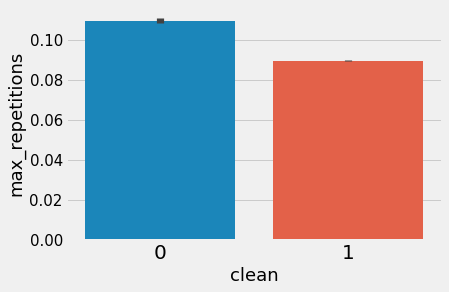

In [ ]:
# compare repetitions - identify possibility of trolls, etc.
sns.barplot(x = 'clean', y = 'max_repetitions', data = features_df)

# hypothesis test
cat1 = features_df[features_df['clean'] == 0]
cat2 = features_df[features_df['clean'] == 1]
t = ttest_ind(cat1['max_repetitions'] , cat2['max_repetitions'], equal_var = False)
print("t-test: " + str(t.statistic))
print("p-value: " + str(t.pvalue))

t-test: 40.33190991126229
p-value: 0.0


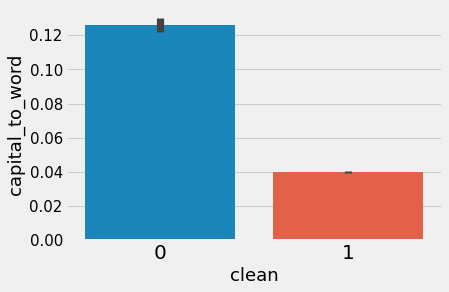

In [ ]:
# compare use/overuse of capitalisation
sns.barplot(x = 'clean', y = 'capital_to_word', data = features_df)

# hypothesis test
cat1 = features_df[features_df['clean'] == 0]
cat2 = features_df[features_df['clean'] == 1]
t = ttest_ind(cat1['capital_to_word'] , cat2['capital_to_word'], equal_var = False)
print("t-test: " + str(t.statistic))
print("p-value: " + str(t.pvalue))

# Section 5: Topic Modelling

While visualisation and exploratory analysis give an idea of characteristics that shape words in different classes or categories, we still lack an understanding of what constitutes toxicity and what conversations are fueling it on twitter.

As a first step in this analysis, we perform topic modelling on the comments labelled in one of the 6 toxic classes. For this, Latent Dirichilet Allocation is utilised and common key words within each topic are analysed. 

###Preparation & Preprocessing

Firstly, text is preprocessed to prepare it for the LDA modelling. As a first step, we extract tweets, in the form of word tokens, from one of the six toxic classes into a single list. This is done using the word dictionary created during the preprocessing step.

As a next step, we group commonly occuring bigrams together using the gensim library to better understand where common phrases lie. 

We further use the Bag of Words model to get a simple vector representation of our tweets. Here, each word/token is associated with a unique id. Furthermore, within each tweet, a word is represented with this unique id along with the frequency of that word in the tweet i.e. the count of how many times it appears in the tweet

In [ ]:
# create a list to store tokens for toxic tweets
word_toxic_list = []

# create token list for all toxic categories
for cat in CATEGORIES:
  if cat != 'clean':
    word_toxic_list += word_dict[cat]

# create bigram model using gensim
bigram = gensim.models.Phrases(word_toxic_list, min_count=2, threshold=100) # higher threshold fewer phrases.
bigram_extractor = gensim.models.phrases.Phraser(bigram)

# extract tokens along with commonly occuring bigrams
word_bigrams = [bigram_extractor[tweet] for tweet in word_toxic_list]

# create dictionary using token list
bigram_dictionary = gensim.corpora.Dictionary(word_bigrams)

# remove certain tokens - no token taken that is in less than 5 documents (or tweets)
# also, no word taken that is in above 50% of tweets as this may skew topiss
bigram_dictionary.filter_extremes(no_below = 5, no_above = 0.50)

# create vector representation using Bag of Words
bow_bigrams = [bigram_dictionary.doc2bow(doc) for doc in word_bigrams]

###LDA Modelling

Here, we use the preprocessed data to construct our topic model using LDA. The LDA model takes in the number of topics as an input. To determine the optimal number of topics, we can make use of topic coherence, which is a quantitative way to assess the quality of the topic model, and is based upon semantic similarity among words in a topic.



In [ ]:
# fine tuning overall LDA model - run last
min_topics = 5
max_topics = 15
coherence_list = []
topics_num = list(range(min_topics, max_topics+1))

for i in topics_num:
  # create LDA model
  lda = gensim.models.LdaModel(bow_bigrams, num_topics = i, id2word = bigram_dictionary, passes = 2, \
                               random_state = 42)

  # create evaluation model that will be used to get coherence
  evaluation_model = CoherenceModel(model=lda, texts=word_bigrams, \
                                    dictionary=bigram_dictionary, coherence='c_v')
  
  # extract and append coherence to list
  coherence_list.append(evaluation_model.get_coherence())

Optimal number of topics =  7


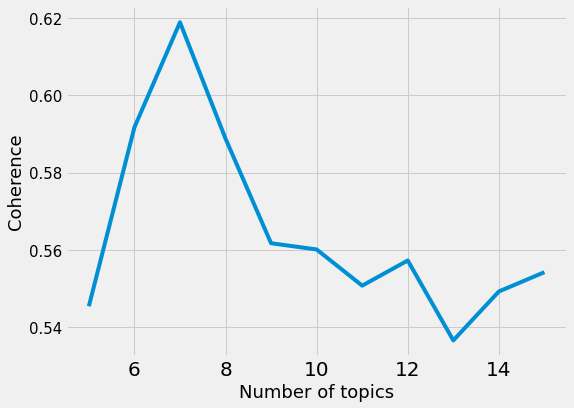

In [ ]:
# plot number of topics against coherence to identify optimal
fig, ax = plt.subplots(figsize = (8, 6))
ax.set_xlabel("Number of topics")
ax.set_ylabel("Coherence")
plt.plot(list(range(min_topics, max_topics+1)), coherence_list)

#Get optimal number of topics
topics_best = topics_num[np.array(coherence_list).argmax()]
print("Optimal number of topics = ", topics_best)

The above graph plots the coherence measure against the number of topics used in creating the model. Observe that the coherence is maximised when the number of topics is 7. We can use this to create our final LDA model below

In [ ]:
# creating final LDA model with the optimal number of topics
lda_final = gensim.models.LdaModel(bow_bigrams, num_topics = topics_best, id2word = bigram_dictionary, passes = 2,\
                                   random_state = 42)

###Visualizing topics

We can now look at each topic along with key defining words within it

In [ ]:
# analyze results/topics created
for topic_no, topic in lda_final.print_topics():
  print("topic", topic_no, '\n', 'topic:', topic)

topic 0 
 topic: 0.053*"hi" + 0.051*"moron" + 0.033*"keep" + 0.022*"talk" + 0.021*"block" + 0.021*"take" + 0.020*"page" + 0.018*"stop" + 0.016*"dont" + 0.015*"retard"
topic 1 
 topic: 0.024*"like" + 0.020*"make" + 0.020*"know" + 0.015*"people" + 0.012*"get" + 0.011*"dickhead" + 0.011*"one" + 0.011*"wikipedia" + 0.010*"say" + 0.010*"article"
topic 2 
 topic: 0.206*"faggot" + 0.123*"shit" + 0.091*"huge" + 0.087*"gay" + 0.087*"hate" + 0.047*"piece" + 0.032*"as" + 0.025*"shut" + 0.024*"cocksucking" + 0.024*"fag"
topic 3 
 topic: 0.331*"nigger" + 0.161*"fat" + 0.153*"jew" + 0.055*"cock" + 0.055*"cunt" + 0.031*"as" + 0.015*"lick" + 0.015*"notrhbysouthbanof" + 0.012*"licker" + 0.010*"spic"
topic 4 
 topic: 0.320*"suck" + 0.214*"die" + 0.076*"dick" + 0.074*"mexican" + 0.046*"love" + 0.022*"wikipedia" + 0.020*"di_edie" + 0.013*"cline" + 0.010*"robert_ullmann" + 0.006*"pathetic"
topic 5 
 topic: 0.387*"fuck" + 0.063*"u" + 0.048*"go" + 0.047*"bitch" + 0.042*"stupid" + 0.026*"eat" + 0.023*"fucker"

The above visual however, is not helpful in interpreting and gathering insights from the topic model To get a better understanding of topics and representative words, we can make use of pyLDAvis imported at the start of this notebook to create a more interactive and interpretable visualisation which shows different topics along with key words for each

In [ ]:
# visualize results
visualizer = pyLDAvis.gensim.prepare(lda_final, bow_bigrams, bigram_dictionary)
pyLDAvis.enable_notebook()
visualizer

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.269230  0.018813       1        1  32.007350
6     -0.216517 -0.022605       2        1  17.257533
5      0.056612 -0.162248       3        1  16.073689
0     -0.248447  0.024826       4        1  10.502243
2      0.216887 -0.096387       5        1   8.592582
3      0.262034 -0.170000       6        1   8.290039
4      0.198661  0.407601       7        1   7.276562, topic_info=        Term          Freq         Total Category  logprob  loglift
29      fuck  39389.000000  39389.000000  Default  30.0000  30.0000
1199  nigger  17289.000000  17289.000000  Default  29.0000  29.0000
148     suck  14674.000000  14674.000000  Default  28.0000  28.0000
271   faggot  11159.000000  11159.000000  Default  27.0000  27.0000
71       die   9809.000000   9809.000000  Default  26.0000  26.0000
...      ...           ...           ...      ...      ...      ...
1063   ha_ha     61.252396     82.671960   Topic7  -6.6186   2.3206
1371    ball    108.034845    394.435403   Topic7  -6.0512   1.3255
339      big    140.989226   1333.634948   Topic7  -5.7850   0.3735
1140    fail     54.973531    178.765293   Topic7  -6.7268   1.4413
132     nice     53.789649    622.554742   Topic7  -6.7486   0.1718

[423 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
246       1  0.728782         add
246       2  0.003406         add
246       4  0.267334         add
82        2  0.993963       ahead
4529      3  0.973163      albino
...     ...       ...         ...
409       1  0.196259         yet
409       2  0.745088         yet
409       4  0.057314         yet
885       1  0.996147       young
6129      3  0.999673  yourselfgo

[814 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 7, 6, 1, 3, 4, 5])

For each word in the topic, the visualisation showcases the overall frequency of the word in the entire set of tweets along with the frequency of the word in the said topic. This gives us a meaningful way to understand key words of a particular topic as a word that is concentrated in the topic (whose overall frequency is close to the in-topic frequency) would be representative of the unique topic as opposed to a word that might be frequent but potentially concenrated evenly across all topics (note that such representative words are what we'll be referring to as key words). With this realisation, we can interpret the topics. Overall, from the interpretations described above, we gathered that toxicity on twitter can be attributed to certain activities and posts made by users that might be the recipient of toxicity, along with racial, cultural, and other biases which seem to be motivating toxicity. There is further an indication of personal attacks being present among toxic tweets. In addition, there is an indication of spam and trolling that is potentially worsening this issue.

**Topics 1, 2, & 4**: These topics appear to be relatively neutral and less filled with expletives than the others. While these seem to be about general conversations, some key words are indicative of people's activities on Twittter such as "ban", "edit", etc. which may indicate that certain behaviors and usages may be driving toxicity against them.

**Topic 3**: This topic just feels generally filled with expletives and profanities that appear to be insults specifically directed at a recipient as opposed to a group.

**Topic 5**:  The topic is filled with toxic words and expletives. Some key words within these topics are definitely indicative of sexism, racism and other biases being a motivation behind the toxicity. Key words such as "minority", "atheist", etc. further indicate that biases against certain groups of people may be motivating toxicity

**Topic 6**: In a similar fashion to topic 5, there is explicit toxicity within this topic and some key words are indicative of racism and other biases fueling toxicuty. Topic 6 further has a number of bigrams, a few of which appear to be "troll-like" repetitions or insults which might also be another dimension to this topic.
 
**Topic 7**: Key Words in this topic are indisputably suggestive of toxicity. The significant presence of the word "die" is perhaps reminiscent of threats or hate directed at a person. Additionally, key words such as "Mexican" may indicate that racism is a potential factor contributing to toxicity 

# Section 6: Modelling



This section encompasses our modelling efforts to predict toxicity. We first begin with the simplified problem of binary classification to identify comments that are toxic or not. 

We then move on to the harder task of multilabel classification to predict the precise classes to which a tweet belongs to in order to construct a model that can capture the nuances of the dataset

##Modelling Clean Vs Toxic

Before looking into all the 7 classes, we first decided to tackle the simplified problem of aiming to predict between clean and toxic comments through a binary classification model. We decided to tackle this first given the similarity and overlap between the toxic categories, and further because this can serve as a blueprint before moving forward to the more complex multilabel classification problem. We look into 3 models here: MultinomialNB since it is quite frequently used in text classification problems, Random Forest Classifiers due to their generally higher performance, and XGBoost since it is efficient and generally has high performance

In [ ]:
# model_df = pd.read_csv('drive/MyDrive/preprocessed_data.csv')
model_df.head()

,Unnamed: 0,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean,capital_to_word,punct_to_word,sent_length,word_count,word_length,num_unique,num_exclamations,max_repetitions,num_stopwords
0,0,0000997932d777bf,explanation edits made username hardcore metal...,0,0,0,0,0,0,1,0.047619,0.238095,1,42,5.309524,40,0.000000,0.071429,0.333333
1,1,000103f0d9cfb60f,matches background colour seemingly stuck,0,0,0,0,0,0,1,0.055556,0.666667,0,18,5.277778,18,0.055556,0.055556,0.055556
2,2,000113f07ec002fd,hey really trying edit guy constantly removing...,0,0,0,0,0,0,1,0.000000,0.142857,0,42,4.571429,39,0.000000,0.071429,0.428571
3,3,0001b41b1c6bb37e,make real suggestions improvement wondered sec...,0,0,0,0,0,0,1,0.035714,0.187500,4,112,4.562500,82,0.000000,0.035714,0.437500
4,4,0001d958c54c6e35,chance remember page,0,0,0,0,0,0,1,0.000000,0.384615,0,13,4.230769,13,0.000000,0.076923,0.307692


We first define a function that summarizes a few valuable evaluation metrics, in order to make it easier for us to compare models used later

In [ ]:
#Define a function to evaluate models
def evaluate_model(y_pred, y_test):
  print("Recall Score =", recall_score(y_pred, y_test))
  print("Precision Score =", precision_score(y_pred, y_test))
  print("F1 Score =", f1_score(y_pred, y_test))
  print("ROC AUC Score =", roc_auc_score(y_pred, y_test))

### Encoding Text

While we have previously extracted metrics from the text, we still do not have a way of factoring the tweet in our model. Over this section, we seek to extract features from the text that can then be used as a part of the modelling process


In [ ]:
# getting x, y and tweets dataframes
x = model_df[list(feats)+['comment_text']]
model_df['is_toxic'] = 1 - model_df['clean']
y = model_df[list(cols)+['is_toxic']]

#Splitting into train and test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.20)

We can begin by utilizing a TF-IDF vectorizer. This vectorizes a text by associating a numerical value to a word which denotes the relevance of the word to a document or in our case, tweet. Here, the value is higher if the word more frequently appears in a particular document or in our case tweets but this increase is offset if the word appears very frequently in the entire set of tweets.

In [ ]:
#Extract text from train and test
text_train = x_train['comment_text'].astype('U').values
text_test = x_test['comment_text'].astype('U').values

#Create and utilise a TfidfVectorizer 
vectorizer = TfidfVectorizer(max_features = 3500, stop_words = 'english', \
                       ngram_range = [1,2], min_df = 10, lowercase = True)
x_train_transformed = vectorizer.fit_transform(text_train)
x_test_transformed = vectorizer.transform(text_test)

#Get toxic/not for binary classification from split
y_train_toxic = y_train['is_toxic']
y_test_toxic = y_test['is_toxic']


#Appending numeric features determined during feature engineering section - led to RAM 
#limit error in future operations 
#and required TFIDF max features to be reduced to a degree that it 
#affected accuracy. Thus, this section is commented out for the time being


# X_train = np.hstack((x_train_transformed.toarray(), x_train.drop(columns = ['comment_text']).values))
# X_test = np.hstack((x_test_transformed.toarray(), x_test.drop(columns = ['comment_text']).values))

As we have seen during the initial visualisations, our dataset is highly imbalanced. This can lead to the models being biased towards the majority class ultimately affecting the performance of our classification algorithm. To tackle, this problem, we have decided to utilise both oversampling of the minority class along with undersampling of the majority class.

For oversampling, we utilise SMOTE or the Synthetic Minority Oversampling Technique, which generates synthetic instances instead of repeating the same instances. For undersampling, we use a classic random technique to undersample instances from the majority class. 


In [ ]:
#Utilise SMOTE to handle imbalance within the dataset
over_sampler = SMOTE(sampling_strategy=0.2)
under_sampler = RandomUnderSampler(sampling_strategy=0.5)
x_train_transformed, y_train_toxic = over_sampler.fit_resample(x_train_transformed, y_train_toxic)
x_train_transformed, y_train_toxic = under_sampler.fit_resample(x_train_transformed, y_train_toxic)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


###Multinomial NB

In [ ]:
#Implement a basic Naive Bayes classifier as baseline
from sklearn.naive_bayes import MultinomialNB
nb_classifier = MultinomialNB()
nb_classifier.fit(x_train_transformed, y_train_toxic)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [ ]:
#Extract predictions and evaluate model
nb_pred = nb_classifier.predict(x_test_transformed)
evaluate_model(nb_pred, y_test_toxic)

Recall Score = 0.6073636874648679
Precision Score = 0.6692474450294209
F1 Score = 0.6368056578753499
ROC AUC Score = 0.7848505146073503


In [ ]:
print("NB Accuracy = ", accuracy_score(nb_pred, y_test_toxic))

NB Accuracy =  0.9227635907880307


###Random Forest

In [ ]:
#Implement a random forest classifier with grid search
rfc_cv = RandomForestClassifier(class_weight = 'balanced')

#Define parameter grid for GridSearch
param_grid = { 
    'n_estimators': [200],
    'max_depth': [40, 80, 120]
}

#Implement GridSearch to extract optimal classifier
CV_forest = GridSearchCV(estimator = rfc_cv, param_grid = param_grid, cv = 2, verbose = 1)
classifier_csv = CV_forest.fit(x_train_transformed, y_train_toxic)

rfc_cv = classifier_csv.best_estimator_
rfc_cv

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  3.8min finished


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=120, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=200,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
#Extract predictions and evaluate model
rfc_cv_pred = rfc_cv.predict(x_test_transformed)
evaluate_model(rfc_cv_pred, y_test_toxic)

Recall Score = 0.5937770095073466
Precision Score = 0.6382781046763704
F1 Score = 0.6152238805970148
ROC AUC Score = 0.7763569339478795


In [ ]:
print("Random Forest Accuracy = ", accuracy_score(rfc_cv_pred, y_test_toxic))

Random Forest Accuracy =  0.9192229359235469


###XGBoost

In [ ]:
#Implement an XGBoost Classifier
xgb_classifier = XGBClassifier()

#Define parameter grid for GridSearch
param_grid = { 
    'n_estimators': [100],
    'max_depth': [20, 50, 80]
}

#Implement GridSearch to extract optimal classifier
cv_xgb = GridSearchCV(estimator = xgb_classifier, param_grid = param_grid, cv = 2, verbose = 1)
cv = cv_xgb.fit(x_train_transformed, y_train_toxic)

xgb_cv = cv.best_estimator_
xgb_cv

Fitting 2 folds for each of 3 candidates, totalling 6 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  8.4min finished


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=80,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [ ]:
#Extract predictions and evaluate model
xgb_cv_pred = xgb_cv.predict(x_test_transformed)
evaluate_model(xgb_cv_pred, y_test_toxic)

Recall Score = 0.6749747389693499
Precision Score = 0.6206255806751316
F1 Score = 0.6466602129719264
ROC AUC Score = 0.8163272782803634


In [ ]:
#Get model accuracy
print("XGBoost Accuracy = ", accuracy_score(xgb_cv_pred, y_test_toxic))

XGBoost Accuracy =  0.9313802287325709


We see here that the Random Forest Model tends to perform slightly worse than the MultinomialNB model in terms of F1 score, however the XGBoost model performs the best with an F1 score of ~0.65. We consider F1 score as a good metric to evaluate our model here since it balances between precision and recall and thus, does not give inflated results like accuracy does in the case of class imbalance which exists within our test set (note that we do not apply over and under sampling to test data as we are trying to keep it as close to the prediction task that the algorithm might face when in production)

##Multilabel Classification

Now, we move on to tackling a more complex problem i.e. multilabel classification. While a binary classification model would likely work to detect comments that are likely to be toxic, we are interested in creating a model that can pinpoint if the tweet is clean or not and if not then which of the 6 given categories of toxicity the tweet belongs to.

Since each tweet can be associated with more than one category of toxicity, we treat this problem as "multilabel" instead of "multiclass" and under this section, we will experiment with a few models in order to tackle this problem (note for each of these we use micro metrics which are those that consider false positives/false negatives of all classes as a whole).

###Binary Relevance

The first technique we utilise for the multiclass classification problem is binary relevance. This technique is equivalent to construct 7 different classifiers i.e. one for each category (including "clean"). The outputs of these classifiers are then collected and merged in order to identify which classes the tweet belongs to.

Instead of implementing this through a loop, we make use of a direct implementation provided by scikit-multilearn. Here, we have utilised the MultinomialNB classifier for each of the 7 models for the purpose of feasibility since using more complex classifiers such as XGBoost resulted in the session crashing due to limit on RAM availability. Regardless, the MultinomialNB classifier gave us fairly good results in the initial modelling section and thus, could potentially be a good fit here

In [ ]:
#Extract vectorized text
vectorizer = TfidfVectorizer(max_features = 3500, stop_words = 'english', \
                       ngram_range = [1,2], min_df = 10, lowercase = True)
x_train_transformed = vectorizer.fit_transform(text_train)
x_test_transformed = vectorizer.transform(text_test)

In [ ]:
#Remove is_toxic from y_train and y_test - run this only for the first time
# y_train = y_train.drop(columns = ['is_toxic'])
# y_test = y_test.drop(columns = ['is_toxic'])

#Define classifier
br_classifier = BinaryRelevance(MultinomialNB())

#fit model
br_classifier.fit(x_train_transformed, y_train)

#Extract predictions
br_predictions = br_classifier.predict(x_test_transformed)

In [ ]:
#Extract metrics for evaluation
print("Accuracy = ",accuracy_score(y_test,br_predictions))
print("Precision = ", precision_score(y_test, br_predictions, average = 'micro'))
print("Recall = ", recall_score(y_test, br_predictions, average = 'micro'))
print("F1 Score = ", f1_score(y_test, br_predictions, average = 'micro'))
print("ROC Score = ", roc_auc_score(y_test, br_predictions.toarray(), average = 'micro'))

Accuracy =  0.9119849600501332
Precision =  0.9341131181522061
Recall =  0.8839105581708138
F1 Score =  0.9083186961905035
ROC Score =  0.9360288046584769


In addition to the above parameters, another metric we can analyse is Hamming loss. Accuracy is defined in a way such that all labels associated with a tweet must be identified correctly for the classification to count as correct. However, it is likely that the classifier might get 3 out of 4 labels right and 1 wrong when classifying a tweet. Thus, hamming loss identifies the fraction of labels that are misclassified and thus, gives an understanding of the classifiers performance in multilabel classification. Here, we see hamming loss is around 3% i.e. around 3% of labels are incorrectly identified which suggests that the classifier performed fairly well. 

In [ ]:
print("Test Hamming loss = {:.2f} %".format(hamming_loss(y_test, br_predictions)*100))

Test Hamming loss = 2.85 %


###Classifier Chains

Classifier chains are an alternate technique to multilabel classification. Here we also build one classifier per class however, each classifier utilises the output of previously trained classifiers in order to factor any potential relationship/potential correlation between the classes. For a similar reason as above, we once again use the MultinomialNB classifier as the base

In [ ]:
#Define chain classifier
chain_classifier = ClassifierChain(MultinomialNB())

#Fit classifier to data
chain_classifier.fit(x_train_transformed, y_train)

#Extract predictions
predictions_chain = chain_classifier.predict(x_test_transformed)

In [ ]:
#Get evaluation metrics
print("Accuracy = ",accuracy_score(y_test,predictions_chain))
print("Precision = ",precision_score(y_test, predictions_chain, average = 'micro'))
print("Recall = ",recall_score(y_test, predictions_chain, average = 'micro'))
print("F1 score = ", f1_score(y_test, predictions_chain, average = 'micro'))
print("ROC AUC = ",roc_auc_score(y_test, predictions_chain.toarray(), average = 'micro'))

Accuracy =  0.9005796647344508
Precision =  0.8837075732297678
Recall =  0.9053743555256669
F1 score =  0.8944097659547965
ROC AUC =  0.9413616185433701


Hamming loss here is around 3.40% as seen below indicating that around 3.40% of labels are misidentified which, although slightly worse than the Binary Relevance classifier, is indicative that the model performed fairly well.

In [ ]:
print("Test Hamming Loss = {:.2f}%".format(hamming_loss(y_test, predictions_chain.toarray())*100))

Test Hamming Loss = 3.41%


### Natural Language Modelling

So far, the models we have developed have been built using extracted features from the text. We can now generate a model that utilizes the raw text itself to predict the labels of a particular comment. A leading model in industry to do so are LSTM models, which are based on the family of Neural Network algorithms but allow for sequences of time to be accounted for. We will now explore its application to the given data problem. 

In [ ]:
# load in x set to be simply text column
x = model_df['comment_text'].astype("U")
y = model_df[list(cols)]

In [ ]:
# create tokenizer for LSTM input
tok = Tokenizer(num_words = 25000)
tok.fit_on_texts(x)

x = tok.texts_to_sequences(x)
x = sequence.pad_sequences(x, maxlen = 200)

In [ ]:
# create LSTM framework with input
inp = Input(shape = (200, ))
layer = Embedding(25000, 128)(inp)
layer = Bidirectional(LSTM(50, return_sequences = True, recurrent_dropout = 0.15))(layer)
layer = GlobalMaxPool1D()(layer)
layer = Dropout(0.2)(layer)
layer = Dense(100, activation = 'relu')(layer)
layer = Dropout(0.2)(layer)
layer = Dense(25, activation = 'relu')(layer)
layer = Dropout(0.2)(layer)
layer = Dense(7, activation = 'sigmoid')(layer)
classifier = Model(inputs = inp, outputs = layer)
classifier.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics=['accuracy'])

In [ ]:
# split the dataset, create callback functions and train the model for 1 epoch
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.25)

checkpoint = ModelCheckpoint('best', monitor = 'val_loss', verbose = 1, save_best_only = True)
early_stop = EarlyStopping(monitor = 'val_loss', patience = 1)

h = classifier.fit(x_train, y_train, batch_size = 32, epochs = 1, validation_split = 0.2, \
                   callbacks = [checkpoint, early_stop])

2992/2992 [==============================] - ETA: 0s - loss: 0.1076 - accuracy: 0.9274
Epoch 00001: val_loss improved from inf to 0.07596, saving model to best
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: best/assets
2992/2992 [==============================] - 1471s 492ms/step - loss: 0.1076 - accuracy: 0.9274 - val_loss: 0.0760 - val_accuracy: 0.9491


In [ ]:
# make predictions and evaluate results 
y_pred = classifier.predict(x_test)
y_pred = np.round(y_pred, 0)

#Visualize predictions
print(y_pred[:5])

[[0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 1.]]


In [ ]:
#Extract evaluation metrics
print("Accuracy = ",accuracy_score(y_test,y_pred))
print("Precision = ",precision_score(y_test, y_pred, average = 'micro'))
print("Recall = ",recall_score(y_test, y_pred, average = 'micro'))
print("F1 Score =", f1_score(y_test, y_pred, average = 'micro'))
print("ROC AUC = ",roc_auc_score(y_test, y_pred, average = 'micro'))

Accuracy =  0.9119645050510115
Precision =  0.9325568548015837
Recall =  0.9082838246833315
F1 Score = 0.9202603096003362
ROC AUC =  0.9478984647653167


Hamming loss for the LSTM model is the lowest at ~2.5% indicating that only 2.5% of labels were misclassified.

In [ ]:
print("Test Hamming Loss = {:.2f}%".format(hamming_loss(y_test, y_pred)*100))

Test Hamming Loss = 2.51%


## Evaluation

Overall, we see that the XGBoost model faired the best in the "Clean Vs Toxic" prediction task, whereas the LSTM model gave high performance in the multiclass classification. Based on the results obtained, we can clearly see that with additional fine tuning, such models can pave the way for automated content moderation that could prove beneficial to a wide variety of online platforms including those such as Twitter

# Section 7: Challenges Faced

While the project was interesting and indisputably rewarding, we did face a few obstacles during the process.  

*   To begin with, given that neither of us had a specific background in Natural Language Processing, we had to refresh on concepts involving data preprocessing, feature extraction and modelling, all of which were crucial for our analysis. 
*   The dataset being worked with was extremely large. As a result, running it on our processors required significant idle time waiting for models to run and for processes to complete.  To circumvent this to some extent, we attempted to write code that was minimally taxing on the processor - for example, if running a loop that constantly references a large set of words from an external library, we would pre-load the set to avoid having to manage network requests each time the loop was run.
*   We further spent time finding 'creative' ways to process the text in a manner that was not redundant, and could improve the quality of the dataset. This involved doing research on text cleansing strategies and working extensively with regex.
* At times, the code resulted in the session crashing due to RAM limit. This hindered our ability to perform modelling such as including all numerical features we extracted during the Feature Generation section into the training data for the algorithms. Doing so required reducing the number of max_features for the TF-IDF vectorizer leading to a significant loss in the classifier's performance (as otherwise, the session crashed due to the RAM limit). 

# Section 8: Next Steps

With content moderation becoming a key conversation among social media companies, especially given the rising prominence of cyberbullying, we were drawn to tackle this challenge as it can be utilised to boost efficiency or to some degree automate the work of content moderation teams.

We definitely learnt a lot during the process and yielded a model that was able perform the task with an accuracy of nearly 90%, as well as fairly strong Precision, Recall and F-1 scores. Despite this, there are a few steps we foresee in further improving the analysis conducted, which are outlined below.

*   Performing the task on a larger dataset collected over a wider period. This would allow us to analyze trends on a time-series scale, and see whether or not the leading features for each label change over time.
*   Experimenting with other feature extraction techniques such as Word2Vec. This would allow us to get more text-based insight from the comment strings, generating stronger models for prediction.
*   Applying more powerful deep learning techniques such as BERT, a model developed by Google and considered to be a leading method for NLP tasks. This enables stronger prediction models that could push up our accuracy rate to above 95%.
*   Factoring LDA output into the classification model - for example, by considering the topic distribution for every tweet.
* We would further want to append our numerical features to the TF-IDF vectors since this was hindered in the current notebook due to resource limitations on Collab

Overall, the project was an incredible learning experience and we look forward to further exploring NLP within this area and beyond.